In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



from IPython.display import display


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors ='coerce')        #coerce -> replace all nonnumeric values with NaN
df.TotalCharges = df.TotalCharges.fillna(0)
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical = ['tenure','monthlycharges', 'totalcharges']
categorical = [ 'gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [5]:
df.churn = (df.churn == 'yes').astype(int) 

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# now spliting it in train and validation
df_train, df_val = train_test_split(df_train_full, test_size= 0.33, random_state= 11)

y_train = df_train.churn.values
y_val = df_val.churn.values


del df_train['churn']
del df_val['churn']


In [7]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

In [8]:
df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


In [9]:
df_train_full.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

In [10]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

<h4> Training the model

In [11]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [12]:
X_train = dv.transform(train_dict)

In [13]:
model = LogisticRegression(solver='liblinear',random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

<h4> Testing the model with validation dataset

In [14]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]
churn = y_pred>=0.5
churn


array([False, False, False, ..., False,  True, False])

<H4> Accuracy

In [15]:
(y_val == churn).mean()

0.8016129032258065

<h4> Testing with external data

In [16]:
customer = {
    'customerid':'83844-dfsdf',
    'gender': 'female',
    'seniorcitizen':0,
    'partner':'no',
    'dependents':'no',
    'tenure': 41,
    'phoneservice':'yes',
    'multiplelines':'no',
    'internetservice':'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year',
    'paperlessbilling':'yes',
    'paymentmethod':'bank_transfer_(automatic)',
    'monthlycharges':  79.85,
    'totalcharges': 3320.75    
}

In [17]:
X_test = dv.transform([customer])

model.predict_proba(X_test)[0,1]    #keeping only the "true" hard events


0.07332623830781355

In [18]:
customer_2 = {
    'customerid':'83844-dfsdf',
    'gender': 'female',
    'seniorcitizen':0,
    'partner':'yes',
    'dependents':'yes',
    'tenure': 10,
    'phoneservice':'no',
    'multiplelines':'no',
    'internetservice':'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'no',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling':'yes',
    'paymentmethod':'electronic_check',
    'monthlycharges':  400,
    'totalcharges': 500    
}

In [19]:
X_test_2 = dv.transform([customer_2])
model.predict_proba(X_test_2)[:,1]

array([0.61763204])

<h4> Confussion box

In [20]:
t = 0.5         #threshhold at 0.5
predict_churn = (y_pred >=t)
predict_no_churn = (y_pred<t)

actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

true_negative = (predict_no_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()

In [21]:
print(f'TN: {true_negative}, FN: {false_negative}, TP: {true_positive}, FP: {false_positive}')

TN: 1202, FN: 197, TP: 289, FP: 172


In [22]:
confusion_table = np.array(
    [[true_negative, false_positive],
     [false_negative, true_positive]]
)
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [23]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

<H4>ROC Curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


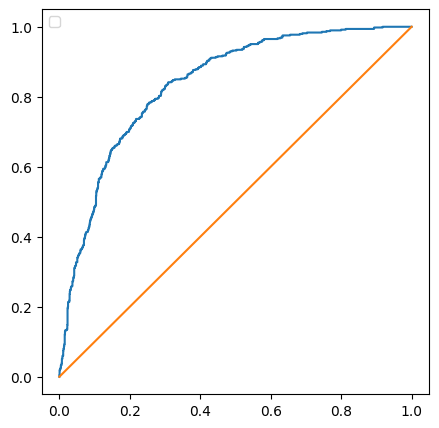

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])


<h4> AUC ROC

In [31]:
auc(fpr, tpr)

0.8363381374257972

<h5> If we only need the AUC, we can skip the ROC curve and use the ROC_AUC_SCORE

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8363381374257972

<h4> K-Fold Cross Validation

In [5]:
def train(df,y):
    cat = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X,y)

    return dv, model

In [6]:
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred


In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)    #split the dataset in 10 parts

aucs = []                                                   #to add the auc scores

for train_idx, val_idx in kfold.split(df_train_full):       # to iterate over the 10 parts
    df_train = df_train_full.iloc[train_idx]                #split the data into train and validation
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)                    #trains the models and make predictions
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)                      #evaluates the quality of the model 
    aucs.append(auc)

In [11]:
aucs

[0.8493392490816277,
 0.8413366336633662,
 0.8590269587894291,
 0.8330260883877869,
 0.8242555831265509,
 0.840959040959041,
 0.8437154021491371,
 0.8223513598987982,
 0.8450570623981029,
 0.8611811367685119]

<h5> Finding the best parameters

In [12]:
def train(df,y,C):                                                      #We add C to the parameters
    cat = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)                 #which we use for the training 
    model.fit(X,y)

    return dv, model

In [16]:
#We loop over different values of C,
#For each C we run cross-validation and record the mean AUC accross all folds as weel as standard deviation

nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)    #split the dataset in 10 parts
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []                                                   #to add the auc scores

    for train_idx, val_idx in kfold.split(df_train_full):       # to iterate over the 10 parts
        df_train = df_train_full.iloc[train_idx]                #split the data into train and validation
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C)                    #trains the models and make predictions
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)                      #evaluates the quality of the model 
        aucs.append(auc)
    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))



C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


<h5> We can see that after C=0.1,the auc doesnt change at all BUT the standard desviation is smaller for 0.5 than for C=.1.<br>
why? when the C parameter is small, the model is more regularized. The weights of this model are more restricted. 

In [17]:
#Now we need to train the model on the entire train and validation datasets and apply it to the test datasets to verify it indeed works well

y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc= roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.859
